In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# --- Parameters ---
N       = 10000  #number of neurons
K       = 1000  #connectivity - each neuron connected to K different neurons

V_T     = 1.0 # voltage threshold
V_R     = 0.0 # voltage reset

nu      = 10*Hz #firing rate
J_0     = 1.0 
tau_m   = 10*ms #membrane time constant

I_0 = nu * J_0 * tau_m 
Iext_const = np.sqrt(K) * I_0 #constant excitatory current
w_inh = J_0/np.sqrt(K) # inhibitory input received

In [17]:
# alter the function slightly to only output the endvector (for lower runtime)

def run_start_end(runtime, startvector):   #enter the runtime in seconds but with the unit
    
    start_scope() 
    defaultclock.dt = 0.1*ms

    # makes use of all variables declared globally, i.e. V_f, V_t, nu, N, K...

    # --- Neuronmodell (Voltage-LIF) ---
    # tau_m dV/dt = -V + I(t) (1), with I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
    eqs = """
    dV/dt = (-V + I_ext)/tau_m : 1  #dimensionless
    I_ext : 1                       #dimensionless constant excitatory current
    """

    G = NeuronGroup(
        N,
        model=eqs,
        threshold="V >= V_T",
        reset="V = V_R",
        method="euler"
    )

    # Initialisierung
    G.V = startvector   #initialize voltage values to start vector
    G.I_ext = Iext_const   #initialize excitatory current with global value

    #connectivity probability
    p = K / (N-1)   # p in (0,1)

    seed(2)           # Brian2 seed
    S = Synapses(G, G, on_pre="V -= w_inh")  # when action potential occurs, decrease the voltage of post-synaptic neuron
    S.connect(condition='i!=j', p=p) # set recurrent connections with probability p, set all self recurrent connections to 0


    #sp_mon = SpikeMonitor(G)
    # mon_all_V = StateMonitor(G, 'V', record=True) #((len(indices), len(t)))
    # popmon = PopulationRateMonitor(G)
    #print(f"\nRunning simulation for T = {runtime}")

    run(runtime)
    mon_endvalues = np.array(G.V) #takes only final voltages

    return mon_endvalues #, mon_all_V, popmon

In [18]:
#starting from the center of a fluxtube

initial_randvector = np.random.rand(N)
#print(initial_randvector)

# V_0, trajectory, popmon = run_start_end(1*second, initial_randvector)
V_0 = run_start_end(0.5*second, initial_randvector)
print(V_0)

# plt.plot(trajectory.t , trajectory.V[0])
# plt.show()
# plt.plot(popmon.t , popmon.smooth_rate(width=0.5*ms))

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


[0.30021147 0.03162278 0.35727089 ... 0.41868578 0.54880308 0.46811885]


In [19]:
# Creating the two normalized random vectors p and q and adding them to the center of a fluxtube

p_vec = np.random.normal(0,1,N)
p_vec /= np.linalg.norm(p_vec)

q_vec = np.random.normal(0,1,N)
q_vec /= np.linalg.norm(q_vec)

# put this into a 20x20 matrix
Vij = np.zeros((20,20,N))

for a in range(0,20):
    for b in range(0,20):
        Vij[a,b] = (-0.01 + a * 0.001) * p_vec + (-0.01 + b * 0.001) * q_vec + V_0


In [20]:
# run this for the 400 conditions
runtime = 10*ms

# create a matrix to store the resulting end vectors
# add a dimension of 1 to add the flux tube group later
end_matrix = np.zeros((20,20,1,N))


for a in range(0,20):
    print(f'Progress is on {a}/20.')
    for b in range(0,20):
        end_matrix[a,b,0] = run_start_end(runtime, Vij[a,b])


Progress is on 0/20.
Progress is on 1/20.
Progress is on 2/20.
Progress is on 3/20.
Progress is on 4/20.
Progress is on 5/20.
Progress is on 6/20.
Progress is on 7/20.
Progress is on 8/20.
Progress is on 9/20.
Progress is on 10/20.
Progress is on 11/20.
Progress is on 12/20.
Progress is on 13/20.
Progress is on 14/20.
Progress is on 15/20.
Progress is on 16/20.
Progress is on 17/20.
Progress is on 18/20.
Progress is on 19/20.


In [ ]:
for i in range(20):
       print(end_matrix[0,i,0])
#[0.62106411, 0.51349036, 0.08041475, ..., 0.10823177, 0.79704109,
       #0.57026998], shape=(10000,))

[0.36580878 0.26461639 0.32498886 ... 0.86200636 0.52250101 0.78661709]
[0.36580558 0.2646157  0.32498762 ... 0.86201265 0.52250475 0.78662087]
[0.36580239 0.264615   0.32498638 ... 0.86201893 0.52250848 0.78662466]
[0.36579919 0.26461431 0.32498514 ... 0.86202521 0.52251222 0.78662844]
[0.40956753 0.14343597 0.48307605 ... 0.55866982 0.63513605 0.71533131]
[0.40956433 0.14343528 0.48307481 ... 0.55867611 0.63513978 0.71533509]
[0.37697415 0.01849325 0.51469941 ... 0.58748423 0.60474492 0.71476401]
[0.37697095 0.01849256 0.51469817 ... 0.58749051 0.60474865 0.71476779]
[0.37696776 0.01849186 0.51469693 ... 0.58749679 0.60475238 0.71477157]
[0.37696456 0.01849117 0.51469568 ... 0.58750307 0.60475612 0.71477536]
[0.37696137 0.01849048 0.51469444 ... 0.58750936 0.60475985 0.71477914]
[0.19904908 0.13879883 0.30978193 ... 0.48829464 0.38993526 0.58899684]
[0.25777473 0.37544363 0.52856538 ... 0.45774475 0.65805058 0.80483666]
[0.25777154 0.37544294 0.52856414 ... 0.45775103 0.65805431 0.80

In [45]:
# create an array which I can use to label the starting points into groups according to their trajectory
group_labels = np.zeros((20,20))

In [60]:
end_matrix[0,19,0]

array([0.25775236, 0.37543878, 0.52855668, ..., 0.45778873, 0.65807671,
       0.80486314], shape=(10000,))

In [88]:
threshold = 1.0  # adjust to your needs

for a in range(20):
    for b in range(20):
        if np.all(group_labels == 0):
            group_labels[a,b] = 1
        else:
            existing_groups = np.unique(group_labels)
            existing_groups = existing_groups[existing_groups != 0]
            
            assigned = False
            for g in existing_groups:
                indices = np.argwhere(group_labels == g)
                
                # Check ALL members of this group
                for i,j in indices:
                    diff = np.abs(end_matrix[a,b,0] - end_matrix[i,j,0]).sum()
                    if diff < threshold:
                        group_labels[a,b] = g
                        assigned = True
                        break
                if assigned:
                    break  # stop checking other groups
            
            if not assigned:
                # Only create new group if none matched
                group_labels[a,b] = int(np.max(group_labels) + 1)


In [76]:
np.abs((end_matrix[0,0,0]-end_matrix[1,0,0])).sum()

np.float64(0.026711665617297688)

In [89]:
group_labels

array([[  1.,   1.,   1.,   1.,   2.,   2.,   3.,   3.,   3.,   3.,   3.,
          4.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
       [  1.,   1.,   1.,   1.,   2.,   3.,   3.,   3.,   3.,   3.,   3.,
          4.,  10.,   5.,   5.,   5.,   5.,   5.,   5.,   5.],
       [  1.,   1.,   1.,   2.,   2.,   3.,   3.,   3.,   3.,   3.,   3.,
         10.,  10.,  16.,   5.,   5.,   5.,   5.,   5.,   5.],
       [ 18.,   1.,   2.,   2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         10.,  23.,  23.,  23.,   5.,   5.,   5.,   5.,   5.],
       [ 18.,  26.,   2.,   2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
          3.,  23.,  23.,  23.,  30.,   5.,   5.,   5.,   5.],
       [ 18.,  26.,  26.,   2.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         36.,  23.,  23.,  23.,  30.,  30.,   5.,   5.,  40.],
       [ 18.,  26.,  26.,  26.,   3.,   3.,   3.,   3.,   3.,  44.,  44.,
         44.,  23.,  23.,  23.,  46.,  46.,  46.,   5.,  40.],
       [ 18.,  18.,  26.,  26.,  26.,  26

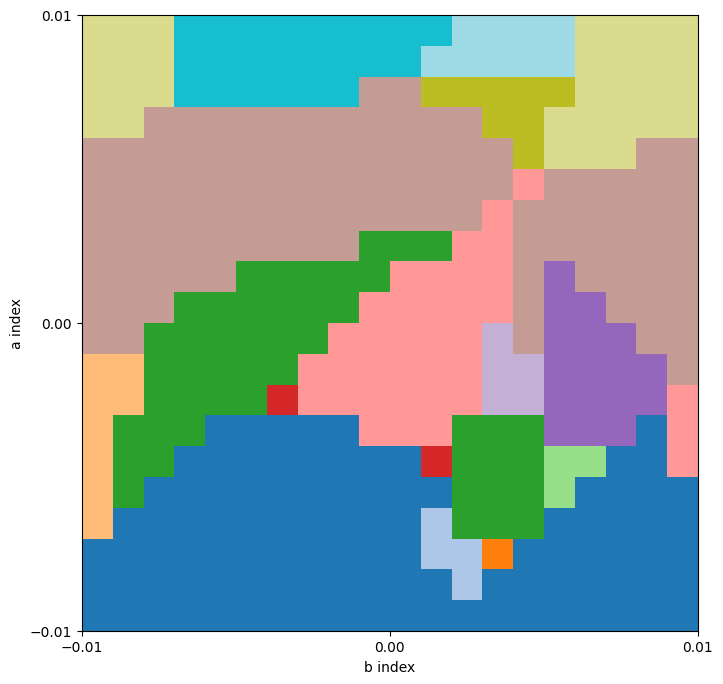

In [99]:
plt.figure(figsize=(8, 8))
plt.imshow(group_labels, cmap='tab20', extent=[-0.01, 0.01, -0.01, 0.01], origin='lower')
plt.xlabel('b index')
plt.ylabel('a index')
plt.xticks([-0.01, 0, 0.01])
plt.yticks([-0.01, 0, 0.01])
plt.show()